# Multi-objective Robust Optimization (MORO)


This exercise demostrates the application of MORO on the lake model. In contrast to the exercises in previous weeks, we will be using a slightly more sophisticated version of the problem. For details see the MORDM assignment for this week.

## Setup MORO

Many objective robust optimization aims at finding decisions that are robust with respect to the various deeply uncertain factors. For this, MORO evalues each candidate decision over a set of scenarios. For each outcome of interest, the robusntess over this set is calculated. A MOEA is used to maximize the robustness. 

For this assignment, we will be using a domain criterion as our robustness metric. The table below lists the rules that you should use for each outcome of interest.

|Outcome of interest| threhsold  |
|-------------------|------------|
| Maximum pollution | $\leq$ 0.75|
| Inertia           | $\geq$ 0.6 |
| Reliability       | $\geq$ 0.99|   
| Utility           | $\geq$ 0.75|

**1) Implement a function for each outcome that takes a numpy array with results for the outcome of interest, and returns the robustness score**

In [1]:
import functools
import numpy as np

def robustness(direction, threshold, data):
    if data.size == 1:
        if direction == SMALLER:
            return float(data <= threshold)
        else:
            return float(data >= threshold)
    else:
        if direction == SMALLER:
            return np.sum(data<=threshold)/data.shape[0]
        else:
            return np.sum(data>=threshold)/data.shape[0]

def maxp(data):
    return np.sum(data<=0.75)/data.shape[0]
    
SMALLER = 'SMALLER'
LARGER = 'LARGER'

maxp = functools.partial(robustness, SMALLER, 0.75)
inertia = functools.partial(robustness, LARGER, 0.6)
reliability = functools.partial(robustness, LARGER, 0.99)
utility = functools.partial(robustness, LARGER, 0.75)




**2) Generate 4 random release policies, and evaluate them over 500 scenarios. Sample the scenarios using Monte Carlo sampling. Next evaulate your robustness function for 1, 2, 3, ... 500 scenarios for each outcome and visualize this. What can you tell about the convergernce of the robusntess metric as a function of the number of scenarios?**

Set up model

In [2]:
import lakemodel_function as lmf
from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, ema_logging, Constant, Constraint)
from ema_workbench.em_framework.evaluators import MC
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
import pandas as pd

lake_model = Model('Lakemodel', function=lmf.lake_problem)

In [30]:
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

lake_model.time_horizon = 100 

lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here



Generate 4 random release policies and evaluate them over 500 scenarios

In [31]:
n_policies = 4

scenarios=[1,2,3,4,5,6,50, 100, 200, 300, 400, 450, 500]

all_results = pd.DataFrame()
with MultiprocessingEvaluator(lake_model) as evaluator:
    for n_scenarios in scenarios:
        experiments, results = evaluator.perform_experiments(policies=n_policies, scenarios=n_scenarios, uncertainty_sampling=MC)
        experiments["max_p"] = results["max_P"]
        experiments["utility"] = results["utility"]
        experiments["inertia"] = results["inertia"]
        experiments["reliability"] = results["reliability"]
        experiments["runs"] = n_scenarios
        all_results = pd.concat([all_results, experiments], axis=0)

In [32]:
grouped = all_results.groupby(by=["runs"])

In [33]:
free_realestate = pd.DataFrame(columns=["max_p", "utility", "inertia", "reliability"])
for group in grouped:
    free_realestate.loc[group[0]] = [maxp(group[1]["max_p"])] + [utility(group[1]["utility"])] + [inertia(group[1]["inertia"])] + [reliability(group[1]["reliability"])]

In [45]:
policy_results = experiments.groupby("policy").mean()
policy_results

,b,delta,mean,q,stdev,l0,l1,l10,l11,l12,...,l95,l96,l97,l98,l99,max_p,utility,inertia,reliability,runs
policy,,,,,,,,,,,,,,,,,,,,,
71,0.274802,0.959987,0.030326,3.275456,0.003079,0.027893,0.014229,0.034301,0.088649,0.031063,...,0.062821,0.038945,0.093251,0.095908,0.020636,3.729064,0.509811,0.626263,0.465929,500
72,0.274802,0.959987,0.030326,3.275456,0.003079,0.080200,0.079411,0.018809,0.056123,0.017368,...,0.036359,0.064828,0.022115,0.048955,0.078400,3.761027,0.587587,0.646465,0.424509,500
73,0.274802,0.959987,0.030326,3.275456,0.003079,0.004857,0.053243,0.083542,0.008870,0.064968,...,0.005924,0.005716,0.053425,0.007125,0.049785,3.762263,0.560882,0.737374,0.432444,500
74,0.274802,0.959987,0.030326,3.275456,0.003079,0.058393,0.032965,0.064742,0.029437,0.079233,...,0.075529,0.078174,0.030515,0.058930,0.053209,3.723809,0.595025,0.585859,0.419803,500


In [49]:
free_realestate

,max_p,utility,inertia,reliability
1,0.750000,0.000000,0.50,0.750000
2,0.500000,0.375000,1.00,0.500000
3,0.083333,0.666667,0.50,0.083333
4,0.000000,0.500000,0.75,0.000000
5,0.200000,0.000000,0.75,0.200000
6,0.416667,0.333333,0.50,0.416667
50,0.340000,0.320000,1.00,0.340000
100,0.325000,0.297500,0.75,0.325000
200,0.335000,0.205000,0.75,0.333750
300,0.315833,0.224167,1.00,0.313333


<AxesSubplot:>

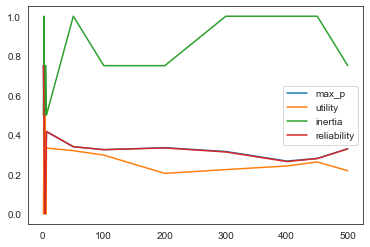

In [34]:
#plot as line graph
free_realestate.plot()


**What does this plot tell us about the influence on number of scenarios on robustness?**

This plot shows that a higher number of runs generally results in convergence in values of robustness metrics. Of interest, however, is that the inertia vlue shows a dramatic change at 500 runs.

Also of interest here is how close the values are for max_p and reliability. This is likely due to similarity in the calculation of their robustness functions.

We realise this plot does not allow us to compare between policies.

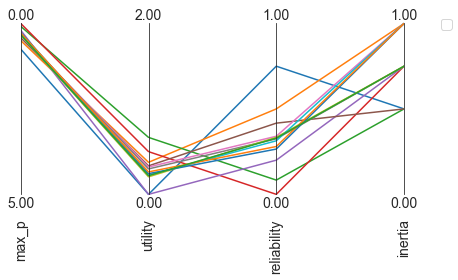

In [41]:
#Plot changes to trade-offs for different number of scenarios
limits = pd.DataFrame([[0,0,0,0],[5,2,1,1]], columns=['max_p', 'utility', 'reliability', 'inertia'])
axes = parcoords.ParallelAxes(limits)
outcomes = free_realestate.loc[:, ['max_p', 'utility', 'reliability', 'inertia']]

# limits = parcoords.get_limits(outcomes)
# axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)
# axes.legend()

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_p') 
plt.show()

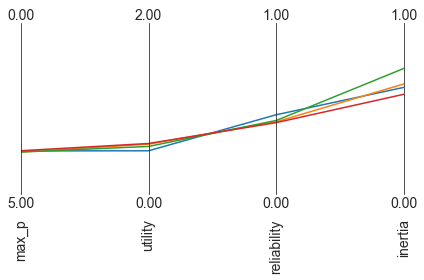

In [48]:
#Plot changes to trade-offs for different policies with 500 scenarios
limits = pd.DataFrame([[0,0,0,0],[5,2,1,1]], columns=['max_p', 'utility', 'reliability', 'inertia'])
axes = parcoords.ParallelAxes(limits)
outcomes = policy_results.loc[:, ['max_p', 'utility', 'reliability', 'inertia']]

#limits = parcoords.get_limits(outcomes)
# axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)
#axes.legend()

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_p') 
plt.show()

## Searching for candidate solutions
Set up the robust optimization problem using the robustness functions you have specified. Assume that you will need 50 scenarios for estimating the robustness. Use $\epsilon$-progress and hypervolume to track convergence. Solve the optimization problem. As $\epsilon$ values, you can assume 0.05 for each of the four robustness metrics.

*note: this optimization problem is computationally very expensive. Develop and test your code using a sequential evaluator, a low number of function evaluations (e.g., 200), and a low number of scenarios (e.g., 5). Once everything seems to be working replace the sequential evaluator with an multiprocessing or ipyparallel evaluator, and increase the number of nfe and scenarios*.


**Plot your $\epsilon$-progress to evaluate convergergence, and visualize the trade-offs using parallel coordinate plots**

In [5]:
from ema_workbench import SequentialEvaluator

In [7]:
nfe = 50000
epsilons = [0.05] * 4
n_scenarios = 50


MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),
                       EpsilonProgress()]

# constraints = [Constraint("max pollution", outcome_names="max_P", function=maxp),
#               Constraint("inertia", outcome_names="inertia", function=inertia),
#               Constraint("reliability", outcome_names="reliability", function=reliability),
#               Constraint("utility", outcome_names="utility", function=utility)]


robustnes_functions = [ScalarOutcome('max_P', kind=MINIMIZE,
                             variable_name='max_P', function=maxp),
                       ScalarOutcome('reliability', kind=MAXIMIZE,
                             variable_name='reliability', function=reliability),
                       ScalarOutcome('inertia', kind=MAXIMIZE,
                             variable_name='inertia', function=inertia),
                       ScalarOutcome('utility', kind=MAXIMIZE,
                             variable_name='utility', function=utility)]


with MultiprocessingEvaluator(lake_model) as evaluator:
    results, convergence = evaluator.robust_optimize(robustnes_functions, n_scenarios, nfe=nfe, epsilons=epsilons, convergence=convergence_metrics)

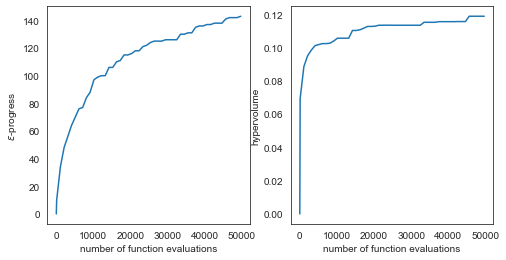

In [8]:
#Plot epsilon progress and convergence
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

The convergence plots show that while hypervolume has mostly stabilised, epsilon-progress is only beginning to stabilise at 50000 evaluations. This suggests that the model should be re-run for 100,000 evaluations. This was not done here in the interests of time. 

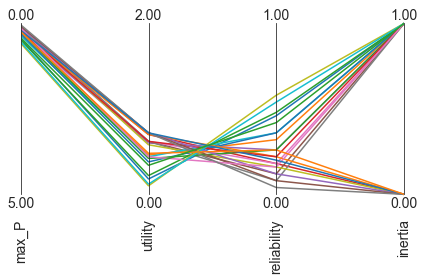

In [16]:
from ema_workbench.analysis import parcoords
limits = pd.DataFrame([[0,0,0,0],[5,2,1,1]], columns=['max_P', 'utility', 'reliability', 'inertia'])
axes = parcoords.ParallelAxes(limits)
outcomes = results.loc[:, ['max_P', 'utility', 'reliability', 'inertia']]

# limits = parcoords.get_limits(outcomes)
# axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P') 
plt.show()

**What does this plot tell us about the tradeoffs and conflicting objectives?**
Under all conditions, there is a clear trade-off between max_P and utility.
Interestingly, the split in values for inertia indicates that max_P objectives can be achieved while also maximising inertia, though not under all conditions.
Achieving the best outcomes for max_P will generally occur at the expense of reliability, though some runs demonstrate that a small increase in max_P can result in marginal improvements to reliability outcomes (though this will occur at the expense of utility).

## Re-evaluate candidate solutions under uncertainty

We have used only 50 scenarios for the optimization. Take the results and re-evaluate them over a larger set (assume 1000 scenarios). How different are your results? What does this imply for the assumption of 50 scenarios during robust optimization.

*hint: use the to_dict method on a dataframe, next generate Policy objects in a list expression by iterating over the dicts returned by the to_dict method*

In [11]:

results_cleaned = results.drop(["max_P", "reliability", "inertia", "utility"], axis=1)
policies = results_cleaned.to_dict('records')

from ema_workbench import Policy
policies = [Policy(**v) for v in policies]

with MultiprocessingEvaluator(lake_model) as evaluator:
    final_experiments, final_results = evaluator.perform_experiments(scenarios=1000, policies=policies)

In [12]:
final_dataset_exp = final_experiments.copy()
final_dataset_res = final_results.copy()
final_dataset_exp["max_p"] = final_dataset_res["max_P"]
final_dataset_exp["utility"] = final_dataset_res["utility"]
final_dataset_exp["inertia"] = final_dataset_res["inertia"]
final_dataset_exp["reliability"] = final_dataset_res["reliability"]

In [19]:
final_dataset_exp

,b,delta,mean,q,stdev,l0,l1,l2,l3,l4,...,l97,l98,l99,scenario,policy,model,max_p,utility,inertia,reliability
0,0.241349,0.971029,0.025911,4.369649,0.001499,0.029824,0.086125,0.023011,0.064086,0.031573,...,0.061616,0.076015,0.02728,32710,0,Lakemodel,0.434206,0.581937,0.626263,1.0000
1,0.249035,0.982925,0.037717,3.784484,0.001513,0.029824,0.086125,0.023011,0.064086,0.031573,...,0.061616,0.076015,0.02728,32711,0,Lakemodel,4.424397,0.845685,0.626263,0.2006
2,0.264004,0.958410,0.048176,3.740858,0.003789,0.029824,0.086125,0.023011,0.064086,0.031573,...,0.061616,0.076015,0.02728,32712,0,Lakemodel,4.212524,0.428730,0.626263,0.1629
3,0.104848,0.934168,0.028757,3.771399,0.003570,0.029824,0.086125,0.023011,0.064086,0.031573,...,0.061616,0.076015,0.02728,32713,0,Lakemodel,10.315330,0.282288,0.626263,0.0800
4,0.346848,0.941845,0.049262,2.040579,0.001420,0.029824,0.086125,0.023011,0.064086,0.031573,...,0.061616,0.076015,0.02728,32714,0,Lakemodel,2.938540,0.316574,0.626263,0.0604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22995,0.418892,0.970912,0.027182,2.287252,0.002658,0.098753,0.098943,0.096085,0.064810,0.031329,...,0.061616,0.076241,0.02728,33705,22,Lakemodel,2.327759,0.770749,0.636364,0.1503
22996,0.195637,0.966873,0.034884,4.452879,0.002390,0.098753,0.098943,0.096085,0.064810,0.031329,...,0.061616,0.076241,0.02728,33706,22,Lakemodel,5.636886,0.695769,0.636364,0.1094
22997,0.239338,0.976286,0.020566,2.929630,0.002744,0.098753,0.098943,0.096085,0.064810,0.031329,...,0.061616,0.076241,0.02728,33707,22,Lakemodel,4.507681,0.896430,0.636364,0.0822
22998,0.225163,0.972593,0.018559,3.734816,0.004810,0.098753,0.098943,0.096085,0.064810,0.031329,...,0.061616,0.076241,0.02728,33708,22,Lakemodel,4.820044,0.806493,0.636364,0.1686


In [27]:
policy_results = final_dataset_exp.groupby("policy").mean()
policy_results

,b,delta,mean,q,stdev,l0,l1,l2,l3,l4,...,l94,l95,l96,l97,l98,l99,max_p,utility,inertia,reliability
policy,,,,,,,,,,,,,,,,,,,,,
0,0.274995,0.96,0.03,3.250058,0.003,0.029824,0.086125,0.023011,0.064086,0.031573,...,0.089954,0.081528,0.056029,0.061616,0.076015,0.027280,3.569341,0.516364,0.626263,0.462109
1,0.274995,0.96,0.03,3.250058,0.003,0.092601,0.094442,0.099867,0.088182,0.063847,...,0.084539,0.092392,0.080029,0.060408,0.015596,0.060557,4.067641,0.814095,0.606061,0.307364
2,0.274995,0.96,0.03,3.250058,0.003,0.078503,0.062195,0.082186,0.013932,0.037597,...,0.057379,0.035477,0.022784,0.021451,0.078967,0.045170,3.615960,0.565702,0.656566,0.446436
3,0.274995,0.96,0.03,3.250058,0.003,0.098522,0.099288,0.098065,0.099210,0.097465,...,0.092059,0.093219,0.097074,0.096259,0.090551,0.085717,4.487953,1.099961,0.050505,0.192898
4,0.274995,0.96,0.03,3.250058,0.003,0.098417,0.071440,0.099333,0.088182,0.065753,...,0.084798,0.081397,0.022726,0.072450,0.014805,0.085680,4.366248,0.978020,0.626263,0.231206
5,0.274995,0.96,0.03,3.250058,0.003,0.098729,0.071425,0.099333,0.088182,0.063792,...,0.084798,0.081404,0.046235,0.072454,0.013240,0.085713,4.388821,0.993436,0.606061,0.222690
6,0.274995,0.96,0.03,3.250058,0.003,0.098373,0.071425,0.099333,0.088182,0.063802,...,0.084798,0.081397,0.046597,0.072454,0.013240,0.085713,4.391488,0.992610,0.606061,0.222455
7,0.274995,0.96,0.03,3.250058,0.003,0.098382,0.071425,0.099333,0.096747,0.063802,...,0.084790,0.081397,0.038146,0.072454,0.013240,0.085714,4.394766,0.997315,0.606061,0.220477
8,0.274995,0.96,0.03,3.250058,0.003,0.098493,0.098751,0.099819,0.097396,0.085458,...,0.085764,0.092401,0.089566,0.062450,0.088390,0.087267,4.330619,0.961688,0.404040,0.247256


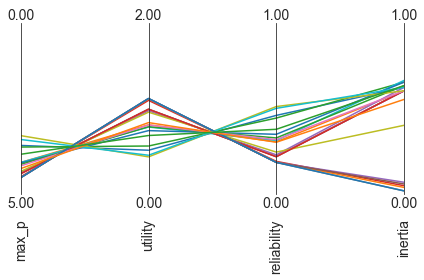

In [29]:
from ema_workbench.analysis import parcoords
limits = pd.DataFrame([[0,0,0,0],[5,2,1,1]], columns=['max_p', 'utility', 'reliability', 'inertia'])
# axes = parcoords.ParallelAxes(limits)
outcomes = policy_results.loc[:, ['max_p', 'utility', 'reliability', 'inertia']]

#limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_p') 
plt.show()

**How do the evaluation results vary from robust optimisation results?**

The most significant difference here is that standard evaluation results tended to favour higher max_P values than for the robust-optimisation. Under these conditions, we also observe less variability/less extremes in the trade-offs between objectives. Again, the inertia results see a split between policies/runs, favouring either strictly high or strictly low inertia.

The utility trade-off is more apparent from these results is more apparent than from the robust-optimisation results.

Domain expertise/consultation would be necessary to understand which types of trade-offs in results are more desirable on the aggregate.

## Comparison
If you have time, import your solutions found for MORDM and re-evaluate them over the same set of scnearios as used for re-evaluating the MORO results. Compare the robustness of MORDM and MORO, what do you observe?

In [ ]:
#nah